In [35]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Layer
from keras.initializers import Constant

import itertools

import matplotlib.pyplot as plt

In [36]:
digits = load_digits()
raw_X, raw_y = digits.data, digits.target
wanted_classes = [1,3,5]
mask = np.isin(raw_y, wanted_classes)
X = raw_X[mask]
y = raw_y[mask]

# Remaping Labels 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

skf= StratifiedKFold(n_splits=3)
X_train = [] 
y_train = []
X_test = []
y_test = []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train.append(X[train_idx].astype('float32'))
    X_test.append(X[test_idx].astype('float32'))

    # Appending Targets (Applying One-Hot Encoding Here)
    # y_encoded[train_idx] gives integers like [0, 2, 1]
    # to_categorical converts them to [[1,0,0], [0,0,1], [0,1,0]]
    y_train.append(to_categorical(y_encoded[train_idx], num_classes=3))
    y_test.append(to_categorical(y_encoded[test_idx], num_classes=3))

X_train = [x / 16.0 for x in X_train]
X_test = [x / 16.0 for x in X_test]

print(f"Features Shape: {type(X_train[0])}")  # Should be (N, 64)
print(f"Targets Shape:  {y_train[0].shape}")

Features Shape: <class 'numpy.ndarray'>
Targets Shape:  (364, 3)


In [37]:

class RBFLayer(Layer):
    def __init__(self, units, betas, initializer=None, **kwargs):
        self.units = units
        self.init_betas = betas
        self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape): # designs the layer
        self.mu = self.add_weight(
            name='mu',
            shape=(self.units, int(input_shape[1])),
            initializer=self.initializer, trainable=True)

        self.betas = self.add_weight(
            name='betas',
            shape=(self.units,),
            initializer=Constant(value=self.init_betas),
            trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Use standard TF operations instead of K.expand_dims
        diff = tf.expand_dims(inputs, axis=1) - self.mu
        l2 = tf.reduce_sum(tf.pow(diff, 2), axis=2)
        res = tf.exp(-1.0 * self.betas * l2)
        return res
    
    def compute_output_shape(self, input_shape): # shape of the output tensor
        return (input_shape[0], self.units)

In [38]:
def f1_score(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    y_true = tf.clip_by_value(y_true, 0, 1) 

    y_pred = tf.round(y_pred)
    y_true = tf.round(y_true)

    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    predicted_positives = tf.reduce_sum(y_pred)
    
    # Avoid division by zero
    epsilon = 1e-7 

    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (possible_positives + epsilon)
    
    return 2 * (precision * recall) / (precision + recall + epsilon)

In [39]:
early_stopping = EarlyStopping(
    monitor='val_loss',       
    mode='min',              
    patience=10,
    start_from_epoch=10,   
    verbose=1,               
    restore_best_weights=True 
)

In [40]:
def init_centers(fold_index , m):
    km = KMeans(n_clusters=m, init='k-means++',
    max_iter=100, verbose=0)
    km.fit(X_train[fold_index])
    centers = km.cluster_centers_.astype('float32')
    return tf.constant_initializer(centers)

In [42]:
param_grid = {
    'm': [32, 64, 96],           
    'betas': [0.1, 0.5, 0.75, 1], 
    'batch_size': [8, 16, 32]}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_score = -1
best_params = {}
best_history = None

fold_index = 0
input_dim = X_train[fold_index].shape[1]
epochs = 50

In [43]:
for i, params in enumerate(combinations):
    print(f"\n [{i+1}/{len(combinations)}] Testing: {params}")
    
    initializer = init_centers(fold_index, params['m'])

    model = keras.Sequential()

    model.add(keras.Input(shape=(input_dim,), dtype='float32'))

    rbflayer = RBFLayer(params['m'], 
                        initializer=initializer,
                        betas=params['betas'])
    
    model.add(rbflayer)
    model.add(layers.Dense(3, activation='softmax', name='rbfk'))

    # 3. Compile
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=[f1_score])


    history = model.fit(X_train[fold_index], 
                        y_train[fold_index], 
                        batch_size=params['batch_size'], 
                        epochs=epochs, 
                        validation_data=(X_test[fold_index], y_test[fold_index]),
                        callbacks=[early_stopping],
                        verbose=0)
    
    scores = model.evaluate(X_test[fold_index], y_test[fold_index], verbose=0)
    
    current_f1 = scores[1] 
    
    print(f"Test F1: {current_f1:.4f}")

    if current_f1 > best_score:
        best_score = current_f1
        best_params = params

print("\n" + "="*40)
print(f"WINNER PARAMS: {best_params}")
print(f"WINNER F1 (Fold 0): {best_score:.4f}")
print("="*40)


 [1/36] Testing: {'m': 32, 'betas': 0.1, 'batch_size': 8}
Restoring model weights from the end of the best epoch: 46.
Test F1: 0.9896

 [2/36] Testing: {'m': 32, 'betas': 0.1, 'batch_size': 16}
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Test F1: 0.9452

 [3/36] Testing: {'m': 32, 'betas': 0.1, 'batch_size': 32}
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Test F1: 0.4458

 [4/36] Testing: {'m': 32, 'betas': 0.5, 'batch_size': 8}
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Test F1: 0.9703

 [5/36] Testing: {'m': 32, 'betas': 0.5, 'batch_size': 16}
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Test F1: 0.8685

 [6/36] Testing: {'m': 32, 'betas': 0.5, 'batch_size': 32}
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Test F1: 0.5403

 [7/36] Testing: {'m': 32, 'betas': 0.75, 'batch_size': 8}
E

In [48]:
final_metrics = {
    'test_loss': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1_score': []
}

all_histories = []

print("\nTraining final model with best params")
for k in range(3):
    print(f"\nTraining final model on fold {k}")

    epochs = 100

    initializer = init_centers(k, best_params['m'])

    model = keras.Sequential()

    model.add(keras.Input(shape=(input_dim,), dtype='float32'))

    rbflayer = RBFLayer(best_params['m'], 
                        initializer=initializer,
                        betas=best_params['betas'])

    model.add(rbflayer)
    model.add(layers.Dense(3, activation='softmax', name='rbfk'))

    model.compile(loss='categorical_crossentropy', 
                    optimizer=keras.optimizers.RMSprop(),
                    metrics=[
                        'accuracy', 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        f1_score])


    history = model.fit(X_train[k], 
                        y_train[k], 
                        batch_size=best_params['batch_size'], 
                        epochs=epochs, 
                        validation_data=(X_test[k], y_test[k]),
                        callbacks=[early_stopping],
                        verbose=0)
    
    all_histories.append(history)

    scores = model.evaluate(X_test[k], y_test[k], verbose=0)

    final_metrics['test_loss'].append(scores[0])
    final_metrics['test_accuracy'].append(scores[1])
    final_metrics['test_precision'].append(scores[2])
    final_metrics['test_recall'].append(scores[3])
    final_metrics['test_f1_score'].append(scores[4])
    
    print(f"Fold {k+1} Result Test F1: {scores[4]:.4f} | Test Acc: {scores[1]:.4f} | Test Prec: {scores[2]:.4f} | Test Rec: {scores[3]:.4f}")

print("\n" + "="*40)
print(f"FINAL AVERAGED RESULTS (Over 3 Folds)")
print("="*40)

for metric_name, values in final_metrics.items():
    avg = np.mean(values)
    std = np.std(values)
    print(f"{metric_name}: {avg:.4f} (+/- {std:.4f})")


Training final model with best params

Training final model on fold 0
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Fold 1 Result Test F1: 0.9697 | Test Acc: 0.9836 | Test Prec: 0.9886 | Test Rec: 0.9508

Training final model on fold 1
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Fold 2 Result Test F1: 0.9799 | Test Acc: 0.9780 | Test Prec: 1.0000 | Test Rec: 0.9615

Training final model on fold 2
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 11.
Fold 3 Result Test F1: 0.9665 | Test Acc: 0.9725 | Test Prec: 0.9724 | Test Rec: 0.9670

FINAL AVERAGED RESULTS (Over 3 Folds)
test_loss: 0.2456 (+/- 0.0655)
test_accuracy: 0.9781 (+/- 0.0045)
test_precision: 0.9870 (+/- 0.0113)
test_recall: 0.9598 (+/- 0.0067)
test_f1_score: 0.9720 (+/- 0.0057)


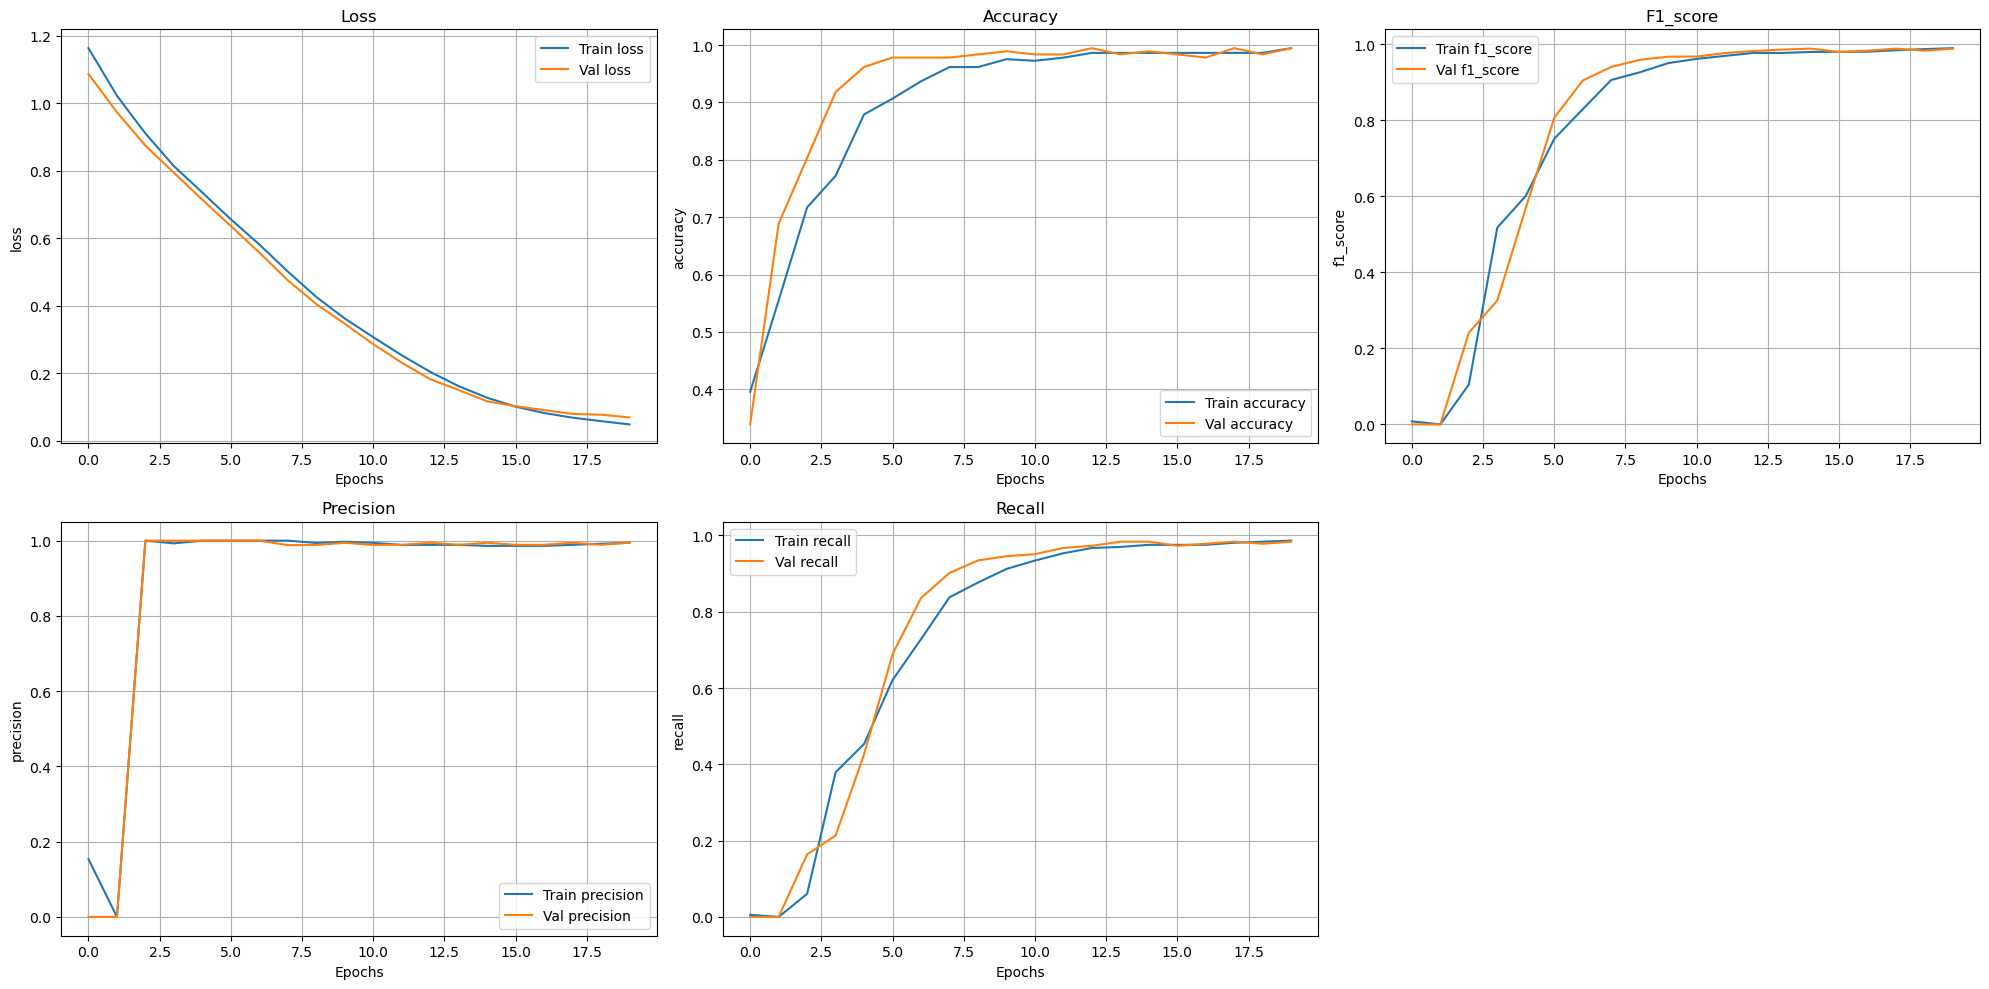

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'f1_score', 'precision', 'recall']
    
    plt.figure(figsize=(20, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        
        # Plot Training
        plt.plot(history.history[metric], label='Train ' + metric)
        
        # Plot Validation
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label='Val ' + metric)
            
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(all_histories[0])